# Proyek Klasifikasi Gambar: Fruit and Vegetables Image Recognition Dataset
- **Nama:** Insania Cindy Puan Fadilahsari
- **Email:** insaniacindy12312@gmail.com
- **ID Dicoding:** insanniaa

## Import Semua Packages/Library yang Digunakan

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools
import random
import pathlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling, Resizing, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications.efficientnet import preprocess_input

import os.path
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError, Image, ImageChops, ImageEnhance

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

sns.set_style('darkgrid')

In [21]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything()

In [22]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
urllib.request.urlretrieve(url, "helper_functions.py")

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Data Preparation

### Data Loading

In [23]:
batch_sz = 32
target_sz = (256, 256)

In [24]:
df = 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset'

walk_through_dir(df)

There are 27 directories and 0 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset'.
There are 0 directories and 88 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\apple'.
There are 0 directories and 93 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\banana'.
There are 0 directories and 109 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\bell pepper'.
There are 0 directories and 112 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\cabbage'.
There are 0 directories and 101 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\carrot'.
There are 0 directories and 99 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\cauliflower'.
There are 0 directories and 104 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\corn'.
There are 0 directories and 114 images in 'D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset\cucu

In [25]:
def convert_path_to_df(df):
    image_dir = Path(df)

    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(df)

In [26]:
path = Path(df).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

C:\Users\ACER\AppData\Local\Temp\ipykernel_19904\4204539603.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\ACER\AppData\Local\Temp\ipykernel_19904\4204539603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


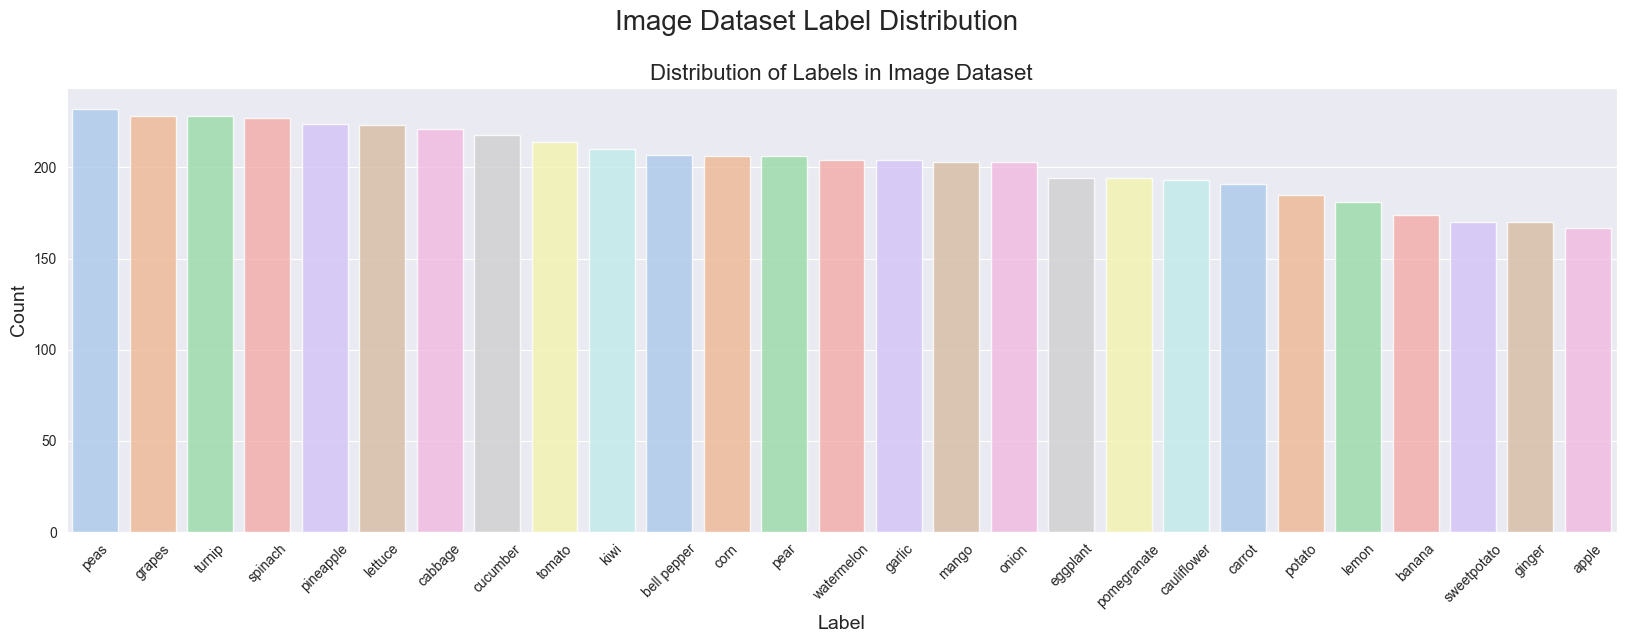

In [27]:
label_counts = image_df['Label'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

fig.suptitle('Image Dataset Label Distribution', fontsize=20)

fig.subplots_adjust(top=0.85)

plt.show()

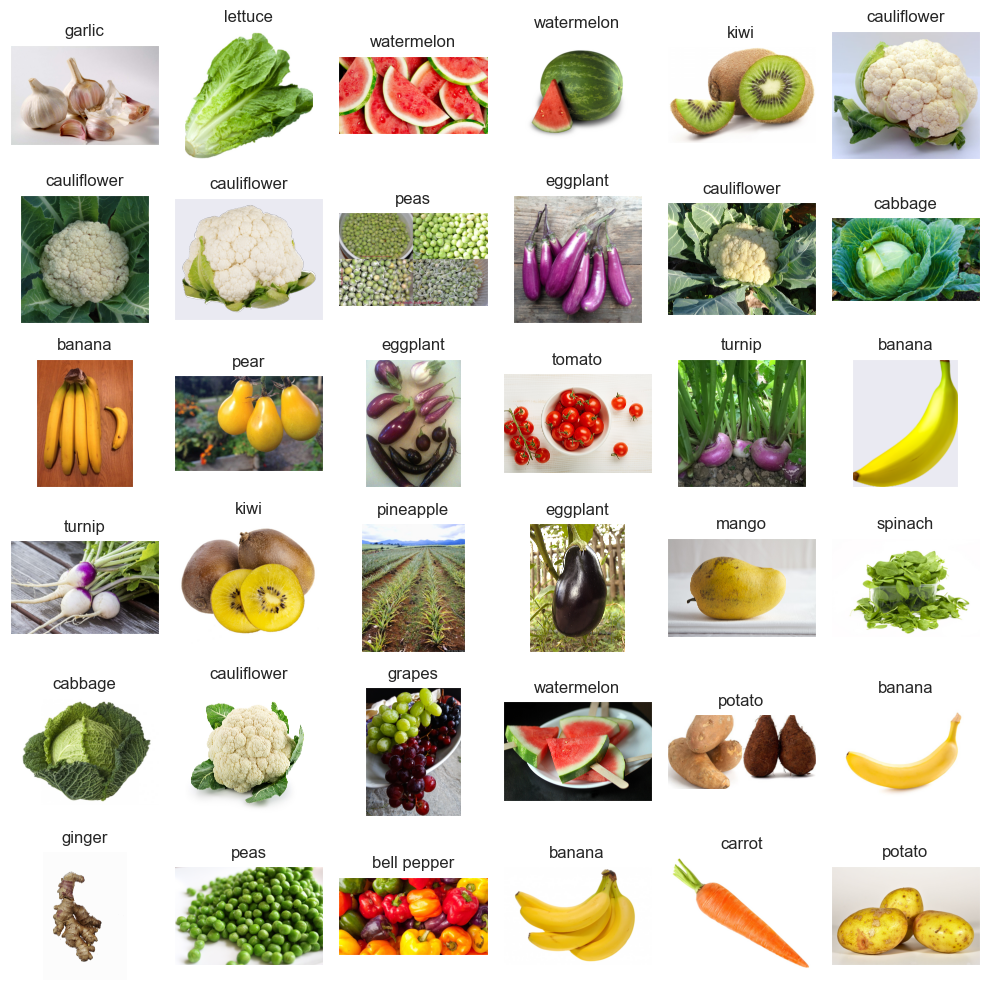

In [28]:
random_index = np.random.randint(0, len(image_df), 36)
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

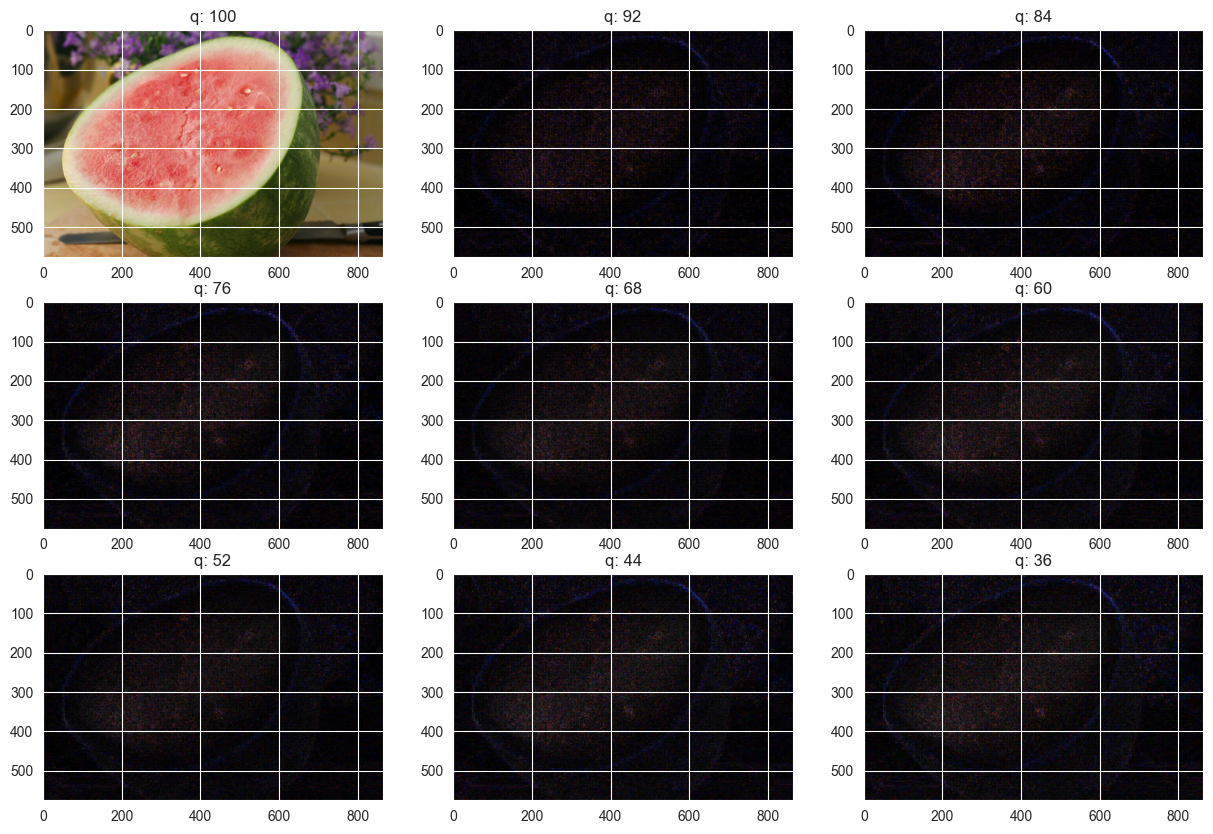

In [29]:
def random_sample(dataset_path):
    all_images = list(Path(dataset_path).rglob("*.jpg")) + \
                 list(Path(dataset_path).rglob("*.jpeg")) + \
                 list(Path(dataset_path).rglob("*.JPG")) + \
                 list(Path(dataset_path).rglob("*.PNG"))
    return str(random.choice(all_images))

def compute_ela_cv(path, quality=90):
    original = Image.open(path).convert('RGB')

    resaved_path = 'temp_ela.jpg'
    original.save(resaved_path, 'JPEG', quality=quality)

    resaved = Image.open(resaved_path)

    ela_image = ImageChops.difference(original, resaved)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return np.array(ela_image) / 255.0

p = random_sample('D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\dataset')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

### Data Preprocessing

#### Split Dataset

In [30]:
def oversample_dataframe(df):
    classes = df['Label'].value_counts().index
    max_size = df['Label'].value_counts().max()
    df_list = [resample(df[df['Label'] == label], replace=True, n_samples=max_size, random_state=42) for label in classes]
    return pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
train_df, test_df = train_test_split(image_df, test_size=0.2, stratify=image_df['Label'], random_state=42)
train_df_oversampled = oversample_dataframe(train_df)

In [32]:
train_data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_data = ImageDataGenerator(preprocessing_function=preprocess_input)

In [33]:
train_generator = train_data.flow_from_dataframe(
    dataframe=train_df_oversampled,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sz,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_data.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sz,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_data.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sz,
    batch_size=batch_sz,
    class_mode='categorical',
    shuffle=False
)

Found 5022 validated image filenames belonging to 27 classes.
Found 4381 validated image filenames belonging to 27 classes.
Found 1096 validated image filenames belonging to 27 classes.


## Modelling

In [34]:
labels_list = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_list),
    y=labels_list
)
class_weights = dict(enumerate(class_weights))

In [35]:
num_classes = len(train_generator.class_indices)

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    layers.Conv2D(64, (3,3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(512, (3,3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(768, (3,3), activation='swish', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),  

    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='swish'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [36]:
checkpoint_path = "fruits_cnn_checkpoint.weights.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
]

In [37]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/100
 11/157 [=>............................] - ETA: 10:27 - loss: 3.3784 - accuracy: 0.1165

d:\Miniconda\envs\main-ds\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


157/157 [==============================] - 892s 6s/step - loss: 2.5814 - accuracy: 0.3037 - val_loss: 2.4475 - val_accuracy: 0.3591 - lr: 1.0000e-04
Epoch 2/100
157/157 [==============================] - 826s 5s/step - loss: 2.0981 - accuracy: 0.4759 - val_loss: 1.9909 - val_accuracy: 0.5129 - lr: 1.0000e-04
Epoch 3/100
157/157 [==============================] - 828s 5s/step - loss: 1.8864 - accuracy: 0.5583 - val_loss: 1.7138 - val_accuracy: 0.6286 - lr: 1.0000e-04
Epoch 4/100
157/157 [==============================] - 836s 5s/step - loss: 1.7148 - accuracy: 0.6217 - val_loss: 1.6886 - val_accuracy: 0.6343 - lr: 1.0000e-04
Epoch 5/100
157/157 [==============================] - 1060s 7s/step - loss: 1.5817 - accuracy: 0.6683 - val_loss: 1.5622 - val_accuracy: 0.6868 - lr: 1.0000e-04
Epoch 6/100
157/157 [==============================] - 1234s 5s/step - loss: 1.4768 - accuracy: 0.7091 - val_loss: 1.4599 - val_accuracy: 0.7202 - lr: 1.0000e-04
Epoch 7/100
157/157 [=======================

## Evaluasi dan Visualisasi

In [38]:
results = model.evaluate(test_generator, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.99551
Test Accuracy: 89.60%


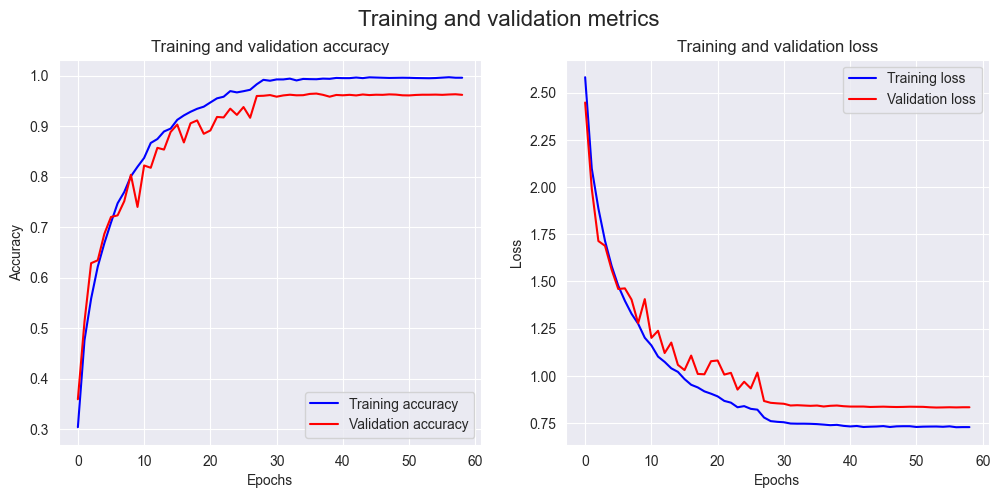

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [40]:
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

35/35 [==============================] - 52s 1s/step
The first 5 predictions: ['sweetpotato', 'eggplant', 'cabbage', 'garlic', 'kiwi']


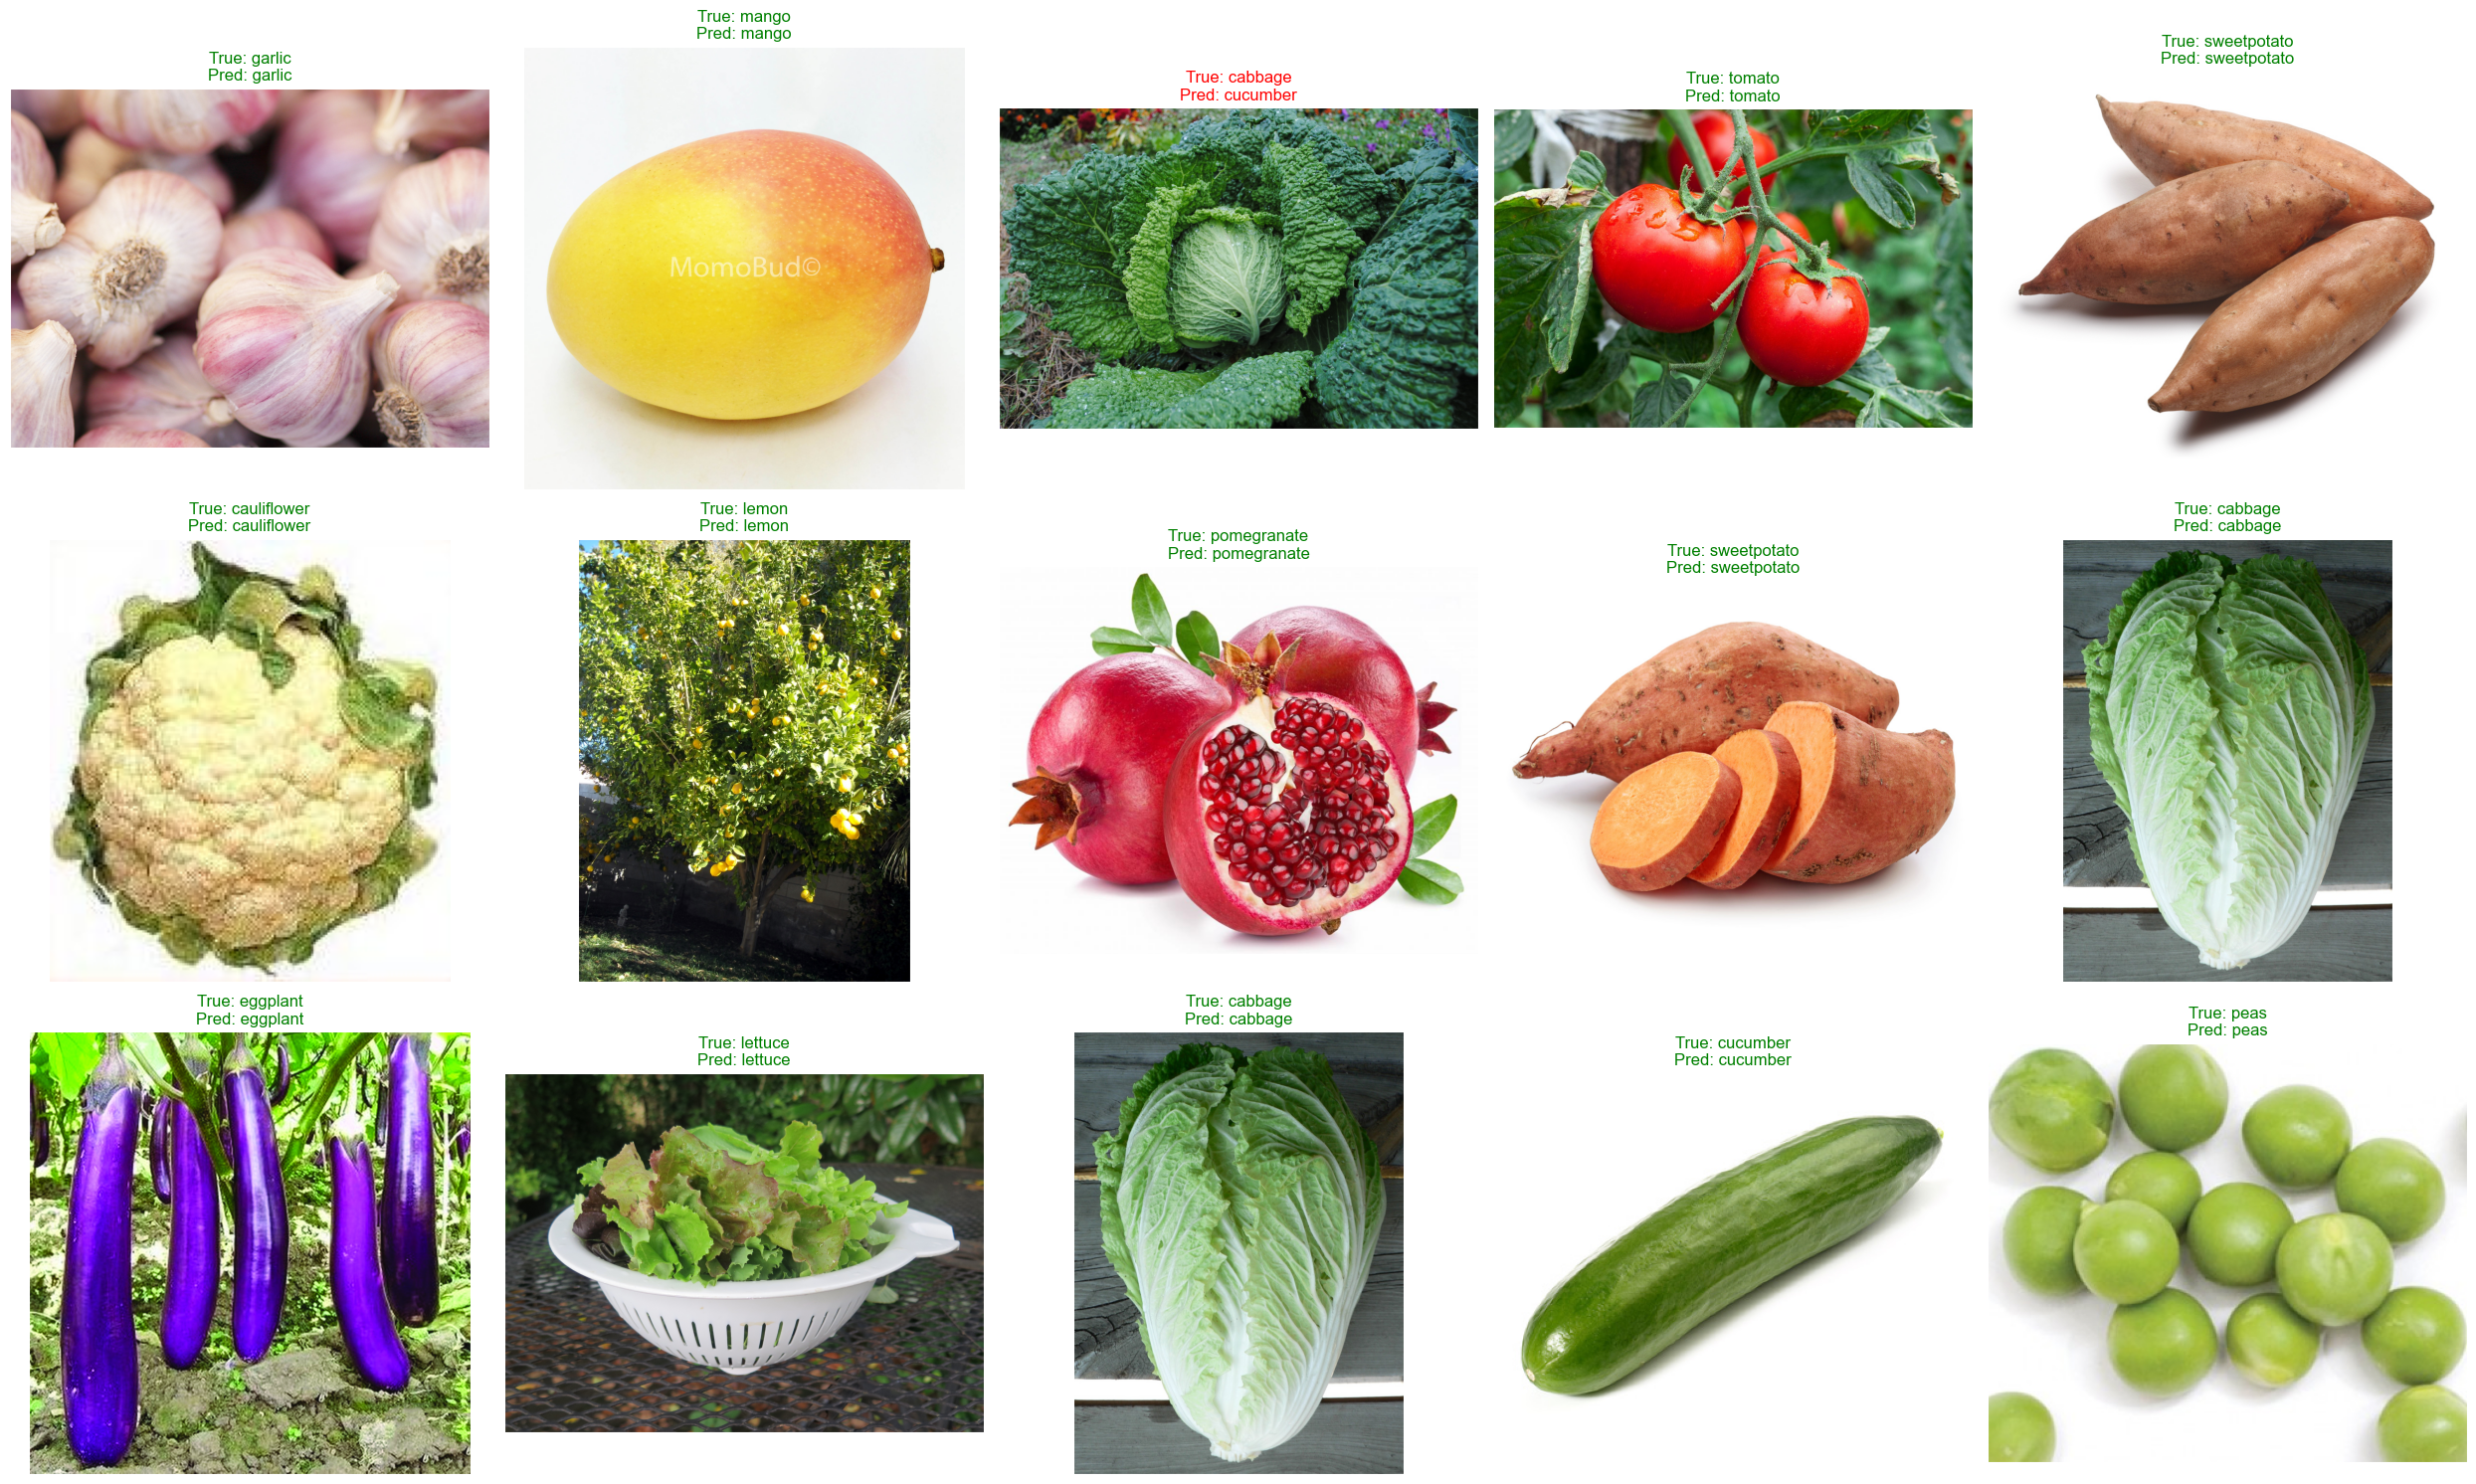

In [41]:
test_df = pd.DataFrame({
    "Filepath": test_generator.filepaths,
    "Label": [os.path.split(os.path.split(x)[0])[1] for x in test_generator.filepaths]
})

random_index = np.random.randint(0, len(test_df), 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(img)
    
    true_label = test_df.Label.iloc[random_index[i]]
    predicted_label = pred[random_index[i]]
    
    color = "green" if true_label == predicted_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()

In [42]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       apple       0.74      0.70      0.72        33
      banana       0.94      0.91      0.93        35
 bell pepper       0.92      0.80      0.86        41
     cabbage       0.80      0.98      0.88        44
      carrot       1.00      1.00      1.00        38
 cauliflower       0.97      0.87      0.92        38
        corn       0.97      0.90      0.94        41
    cucumber       0.91      0.89      0.90        44
    eggplant       0.87      1.00      0.93        39
      garlic       0.90      0.93      0.92        41
      ginger       0.88      0.82      0.85        34
      grapes       0.91      0.91      0.91        46
        kiwi       0.95      0.86      0.90        42
       lemon       0.86      0.89      0.88        36
     lettuce       0.84      0.84      0.84        45
       mango       0.86      0.90      0.88        41
       onion       0.97      0.90      0.94        41
        pear       0.88    

In [43]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
apple          0.741935  0.696970  0.718750    33.000000
banana         0.941176  0.914286  0.927536    35.000000
bell pepper    0.916667  0.804878  0.857143    41.000000
cabbage        0.796296  0.977273  0.877551    44.000000
carrot         1.000000  1.000000  1.000000    38.000000
cauliflower    0.970588  0.868421  0.916667    38.000000
corn           0.973684  0.902439  0.936709    41.000000
cucumber       0.906977  0.886364  0.896552    44.000000
eggplant       0.866667  1.000000  0.928571    39.000000
garlic         0.904762  0.926829  0.915663    41.000000
ginger         0.875000  0.823529  0.848485    34.000000
grapes         0.913043  0.913043  0.913043    46.000000
kiwi           0.947368  0.857143  0.900000    42.000000
lemon          0.864865  0.888889  0.876712    36.000000
lettuce        0.844444  0.844444  0.844444    45.000000
mango          0.860465  0.902439  0.880952    41.000000
onion          0.973684  0.902439  0.936709    41.000000
pear           0.880952  0.902439  0.891566    41.000000
peas           1.000000  0.869565  0.930233    46.000000
pineapple      1.000000  1.000000  1.000000    45.000000
pomegranate    0.868421  0.846154  0.857143    39.000000
potato         0.761905  0.864865  0.810127    37.000000
spinach        0.764706  0.866667  0.812500    45.000000
sweetpotato    0.846154  0.970588  0.904110    34.000000
tomato         0.954545  0.976744  0.965517    43.000000
turnip         0.926829  0.826087  0.873563    46.000000
watermelon     0.950000  0.926829  0.938272    41.000000
accuracy       0.895985  0.895985  0.895985     0.895985
macro avg      0.898190  0.894790  0.894760  1096.000000
weighted avg   0.900104  0.895985  0.896292  1096.000000

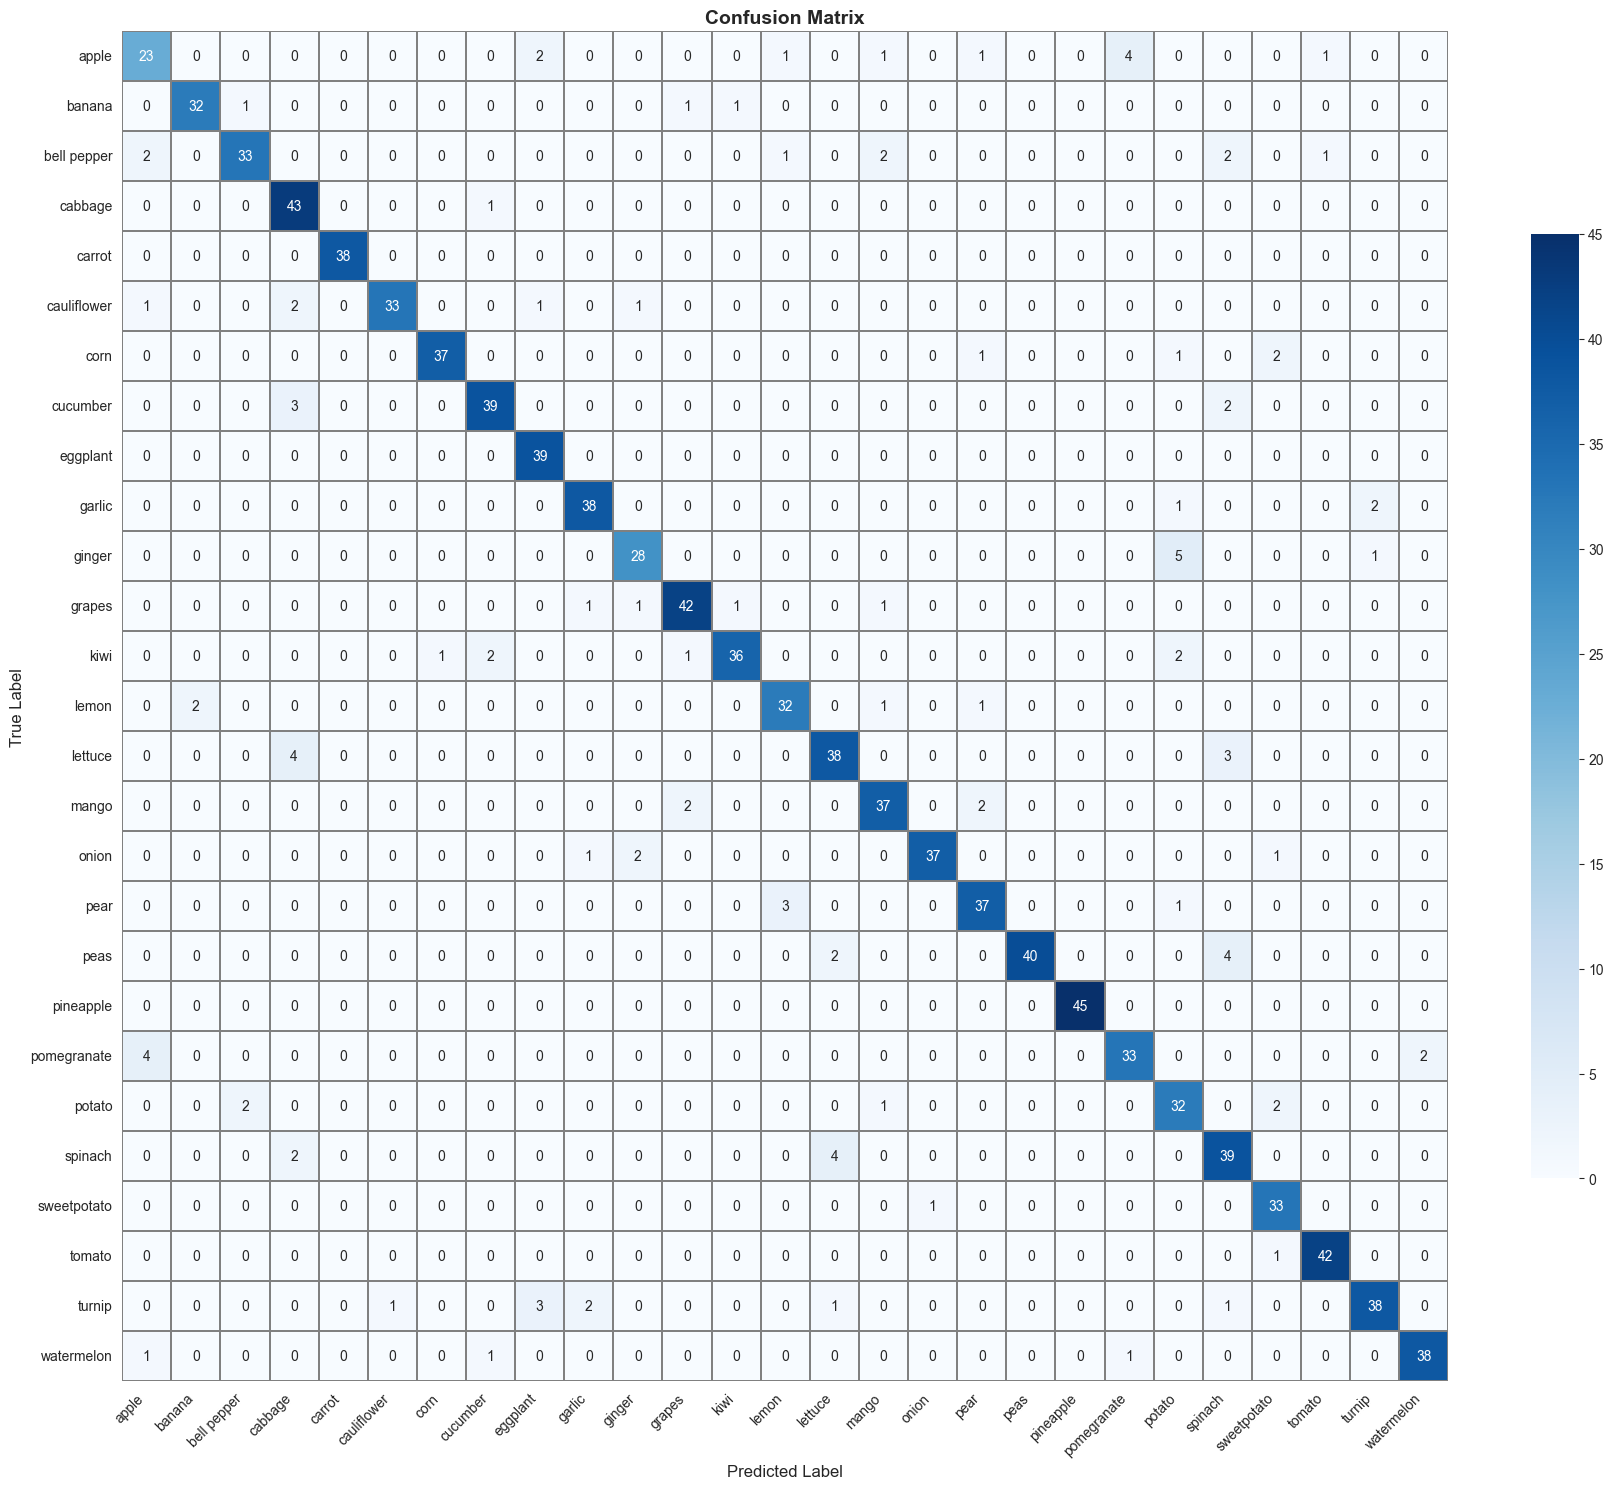

In [44]:
def make_confusion_matrix(y_true, y_pred, classes, figsize=(18, 15), fontsize=10):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes,
                linewidths=0.3, linecolor='gray', cbar_kws={"shrink": 0.7})

    plt.ylabel("True Label", fontsize=fontsize+2)
    plt.xlabel("Predicted Label", fontsize=fontsize+2)
    plt.title("Confusion Matrix", fontsize=fontsize+4, weight='bold')
    plt.xticks(rotation=45, ha="right", fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

make_confusion_matrix(y_test, pred, list(labels.values()))

## Konversi Model

In [45]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


23647584

In [46]:
model.save('model.h5')

d:\Miniconda\envs\main-ds\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model/

2025-04-29 01:50:05.378159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found


In [60]:
!pipreqs "D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy"

INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in D:\dbs_coding_camp\klasifikasi_gambar_revisi - Copy\requirements.txt


In [49]:
def load_and_prepare_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_resized)
    return img_rgb, np.expand_dims(img_preprocessed, axis=0)  

def predict_and_show(image_path, infer, label_map):
    img_rgb, input_tensor = load_and_prepare_image(image_path)

    output = infer(tf.constant(input_tensor, dtype=tf.float32))
    output_key = list(output.keys())[0]
    pred_probs = output[output_key].numpy()
    pred_class_idx = np.argmax(pred_probs)
    pred_label = label_map[pred_class_idx]

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label}", fontsize=16, color='green')
    plt.show()

In [50]:
load_model = tf.saved_model.load('saved_model/')
infer = load_model.signatures['serving_default']

In [51]:
label_map = {v: k for k, v in train_generator.class_indices.items()}

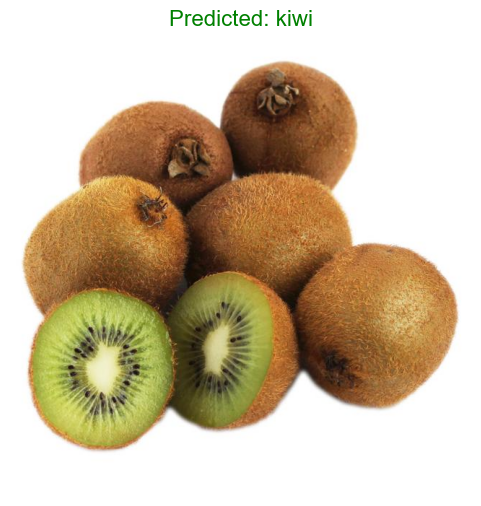

In [52]:
image_path = 'D:/dbs_coding_camp/klasifikasi_gambar/image_test2.jpg'

predict_and_show(image_path, infer, label_map)